In [1]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
feat6_trajs = list(np.load("../../data/raw_feat/feat6_old.npy", allow_pickle=True))
feat6_trajs.extend(np.load("../../data/raw_feat/feat6_anton2.npy", allow_pickle=True))

In [10]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)

feat_arr = np.hstack((sb_arr, np.concatenate(feat6_trajs)))
traj_inds = util.split_indices(cv_trajs)
feat_trajs = np.split(feat_arr, traj_inds)
print(cv_arr.shape, sb_arr.shape, feat_arr.shape)

(4150115, 2) (4150115, 60) (4150115, 90)


In [11]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)
print(rf161_arr.shape)

(4150115, 3)


In [12]:
hb_trajs = list(np.load("../../data/raw_feat/hbonds.npy", allow_pickle=True))
hb_trajs.extend(np.load("../../data/raw_feat/hbonds_anton2.npy", allow_pickle=True))
hb_arr = np.concatenate(hb_trajs)
print(hb_arr.shape)

(4150115, 18)


In [13]:
sb_models = np.load("../../data/models_centroids_feat2.npy")

# Distance basis

In [14]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [15]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down = feat_arr[down_ids]
up = feat_arr[up_ids]
other = feat_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [16]:
assert (
    np.count_nonzero(down_ids) + np.count_nonzero(up_ids) + np.count_nonzero(mask)
) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  37852
Number of up structures:   5400
Number of other structures: 4106863


In [17]:
random.seed(123)

In [18]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

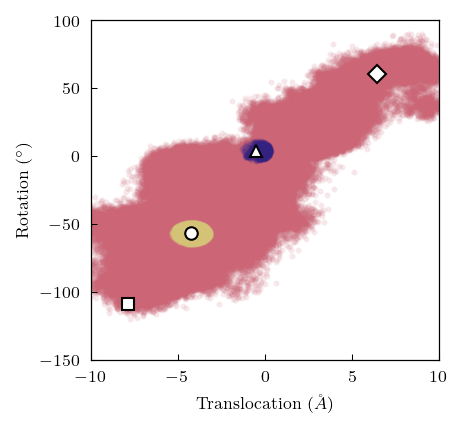

In [19]:
plt.scatter(other_cvs[::10, 0], other_cvs[::10, 1], alpha=0.1)
plt.scatter(up_cvs[::10, 0], up_cvs[::10, 1], alpha=0.1)
plt.scatter(down_cvs[::10, 0], down_cvs[::10, 1], alpha=0.1)
ax = plt.gca()
plotting.format_cvs(ax, ms=6)

## compute distance to states

In [20]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [21]:
d_down = []
counter = 0.0
tot = len(sb_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    feat_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.09% completed
0.17% completed
0.26% completed
0.34% completed
0.43% completed
0.51% completed
0.60% completed
0.68% completed
0.77% completed
0.85% completed
0.94% completed
1.03% completed
1.11% completed
1.20% completed
1.28% completed
1.37% completed
1.45% completed
1.54% completed
1.62% completed
1.71% completed
1.79% completed
1.88% completed
1.96% completed
2.05% completed
2.14% completed
2.22% completed
2.31% completed
2.39% completed
2.48% completed
2.56% completed
2.65% completed
2.73% completed
2.82% completed
2.90% completed
2.99% completed
3.08% completed
3.16% completed
3.25% completed
3.33% completed
3.42% completed
3.50% completed
3.59% completed
3.67% completed
3.76% completed
3.84% completed
3.93% completed
4.01% completed
4.10% completed
4.19% completed
4.27% completed
4.36% completed
4.44% completed
4.53% completed
4.61% completed
4.70% completed
4.78% completed
4.87% completed
4.95% completed
5.04% completed
5.13% completed
5.21% completed
5.30% completed
5.38% co

In [22]:
# Set all distances of point in down state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
d_down_arr[down_ids] = 0

print(d_down_arr.shape)

(4150115, 1)


In [23]:
d_up = []
counter = 0.0
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    feat_arr, up[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.60% completed
1.20% completed
1.80% completed
2.40% completed
2.99% completed
3.59% completed
4.19% completed
4.79% completed
5.39% completed
5.99% completed
6.59% completed
7.19% completed
7.79% completed
8.38% completed
8.98% completed
9.58% completed
10.18% completed
10.78% completed
11.38% completed
11.98% completed
12.58% completed
13.18% completed
13.77% completed
14.37% completed
14.97% completed
15.57% completed
16.17% completed
16.77% completed
17.37% completed
17.97% completed
18.57% completed
19.16% completed
19.76% completed
20.36% completed
20.96% completed
21.56% completed
22.16% completed
22.76% completed
23.36% completed
23.96% completed
24.55% completed
25.15% completed
25.75% completed
26.35% completed
26.95% completed
27.55% completed
28.15% completed
28.75% completed
29.35% completed
29.94% completed
30.54% completed
31.14% completed
31.74% completed
32.34% completed
32.94% completed
33.54% completed
34.14% completed
34.74% completed
35.34% completed
35.93% comple

In [24]:
# Set all distances of point in up state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
d_up_arr[up_ids] = 0

print(d_up_arr.shape)

(4150115, 1)


In [25]:
np.save("../../data/feat6_dist_du_anton2/dist_down", d_down_arr)
np.save("../../data/feat6_dist_du_anton2/dist_up", d_up_arr)

## Basis and smoothing

In [26]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)
guess_up = (d_down_arr ** 2) / (d_down_arr ** 2 + d_up_arr ** 2)

# make smoothing 0 at boundaries (down and up states)
smooth[~mask] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [27]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(4150115, 1) (4150115, 1) (4150115, 1)


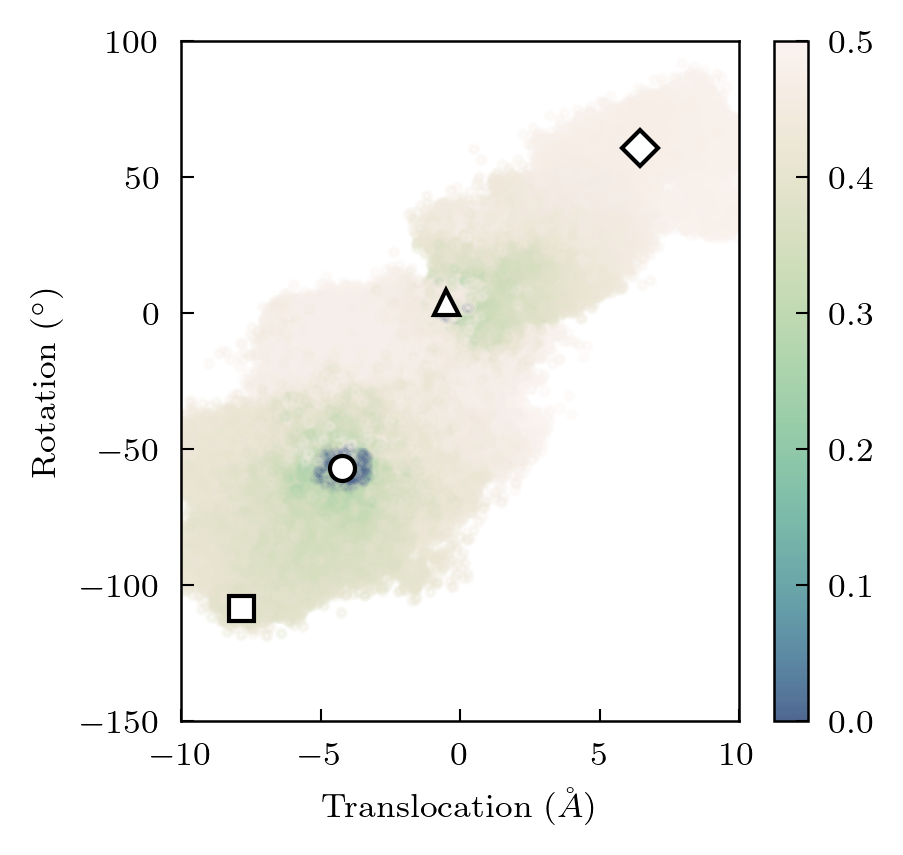

In [28]:
# Plot smoothing function
fig, ax = plt.subplots(dpi=300)
h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=smooth[inds], alpha=0.2, cmap=cm_seq)
# h = ax.scatter(cv_arr[3_000_000:, 0], cv_arr[3_000_000:, 1], c=smooth[3_000_000:], alpha=0.2, cmap=cm_seq)

cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

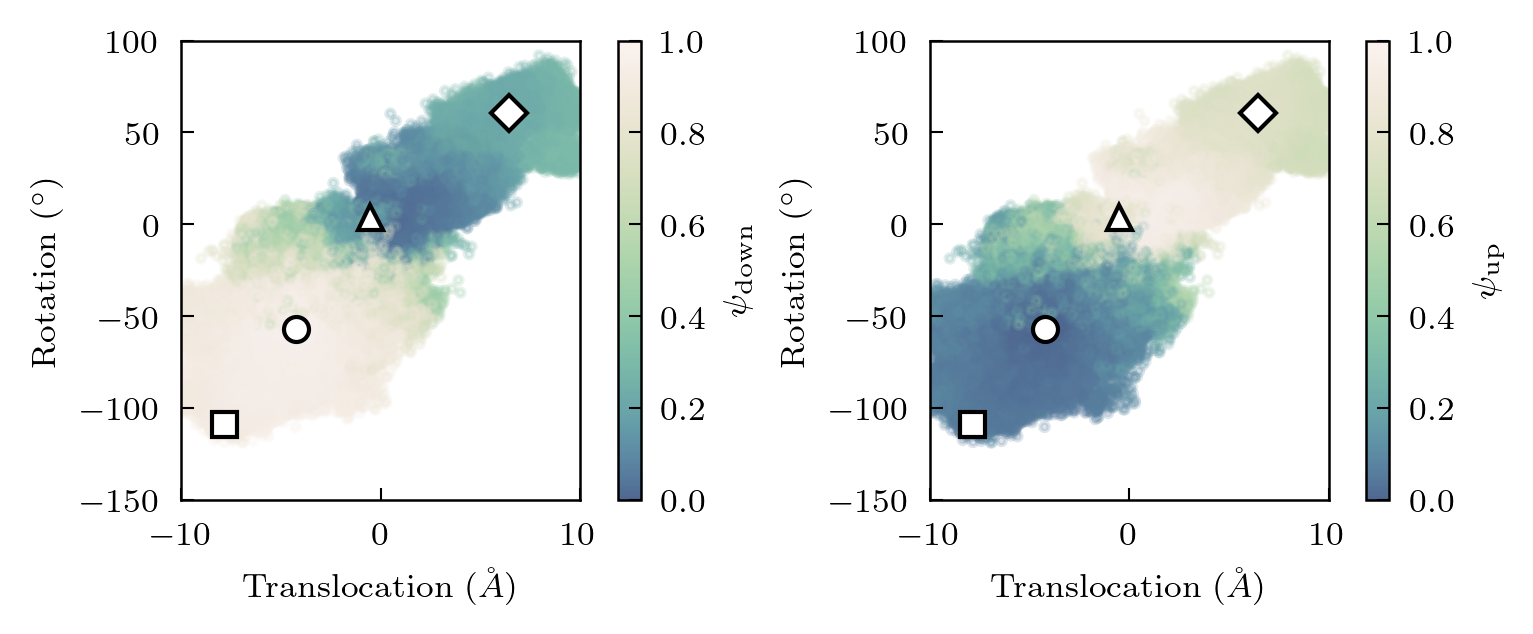

In [29]:
# Plot down and up state guess function
fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=300, constrained_layout=True)
labels = ("$\psi_{\mathrm{down}}$", "$\psi_{\mathrm{up}}$")
for ax, g, label in zip(axs, (guess_down, guess_up), labels):
    h = ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=g[inds], alpha=0.2, cmap=cm_seq)
    cb = plt.colorbar(h, ax=ax, label=label)
    cb.solids.set(alpha=1.0)
    plotting.format_cvs(ax, ms=6)

# DGA weights

In [30]:
# split into lists of arrays
traj_inds = util.split_indices(cv_trajs)

guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

print(len(guessU))
print(len(guessD))

352
352


In [31]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [32]:
weights = np.load("../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)

# Committors

## Basis

In [33]:
basisF_arr = smooth * feat_arr
basisF = []
curr = 0
traj_lens = [len(traj) for traj in cv_trajs]
for t_len in traj_lens:
    basisF.append(basisF_arr[curr : curr + t_len])
    curr += t_len

basis_d = util.orthogonalize(basisF, weights[0])

In [48]:
basisF_arr.shape

(4150115, 90)

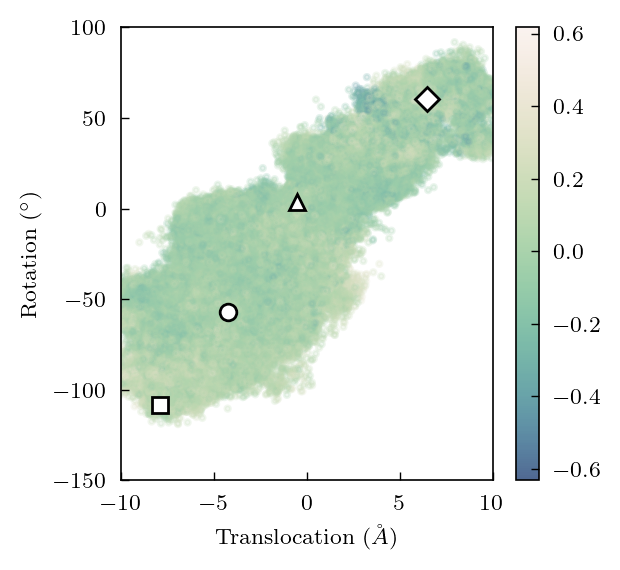

In [34]:
# Plot smoothing function
fig, ax = plt.subplots(dpi=200)
h = ax.scatter(
    cv_arr[inds, 0],
    cv_arr[inds, 1],
    c=np.mean(np.concatenate(basis_d), axis=-1)[inds],
    alpha=0.2,
    cmap=cm_seq,
)
cb = plt.colorbar(h, ax=ax)
cb.solids.set(alpha=1.0)
plotting.format_cvs(ax, ms=6)

In [35]:
assert np.all(np.concatenate(basis_d)[~mask] == False)

## Calculations

In [36]:
# traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)
in_domain[0].shape

(10000,)

In [37]:
len(in_domain)

352

In [38]:
q_downup, qb_downup = [], []
q_updown, qb_updown = [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basis_d, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basis_d, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basis_d, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basis_d, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000


In [39]:
np.save("../../data/feat6_dist_du_anton2/qp_downup_3", q_downup)
np.save("../../data/feat6_dist_du_anton2/qm_downup_3", qb_downup)
np.save("../../data/feat6_dist_du_anton2/qp_updown_3", q_updown)
np.save("../../data/feat6_dist_du_anton2/qm_updown_3", qb_updown)
# q_downup = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)
# qb_downup = np.load("../../data/feat2_dist_du_anton2/qm_downup_3.npy", allow_pickle=True)
# q_updown = np.load("../../data/feat2_dist_du_anton2/qp_updown_3.npy", allow_pickle=True)
# qb_updown = np.load("../../data/feat2_dist_du_anton2/qm_updown_3.npy", allow_pickle=True)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Plots

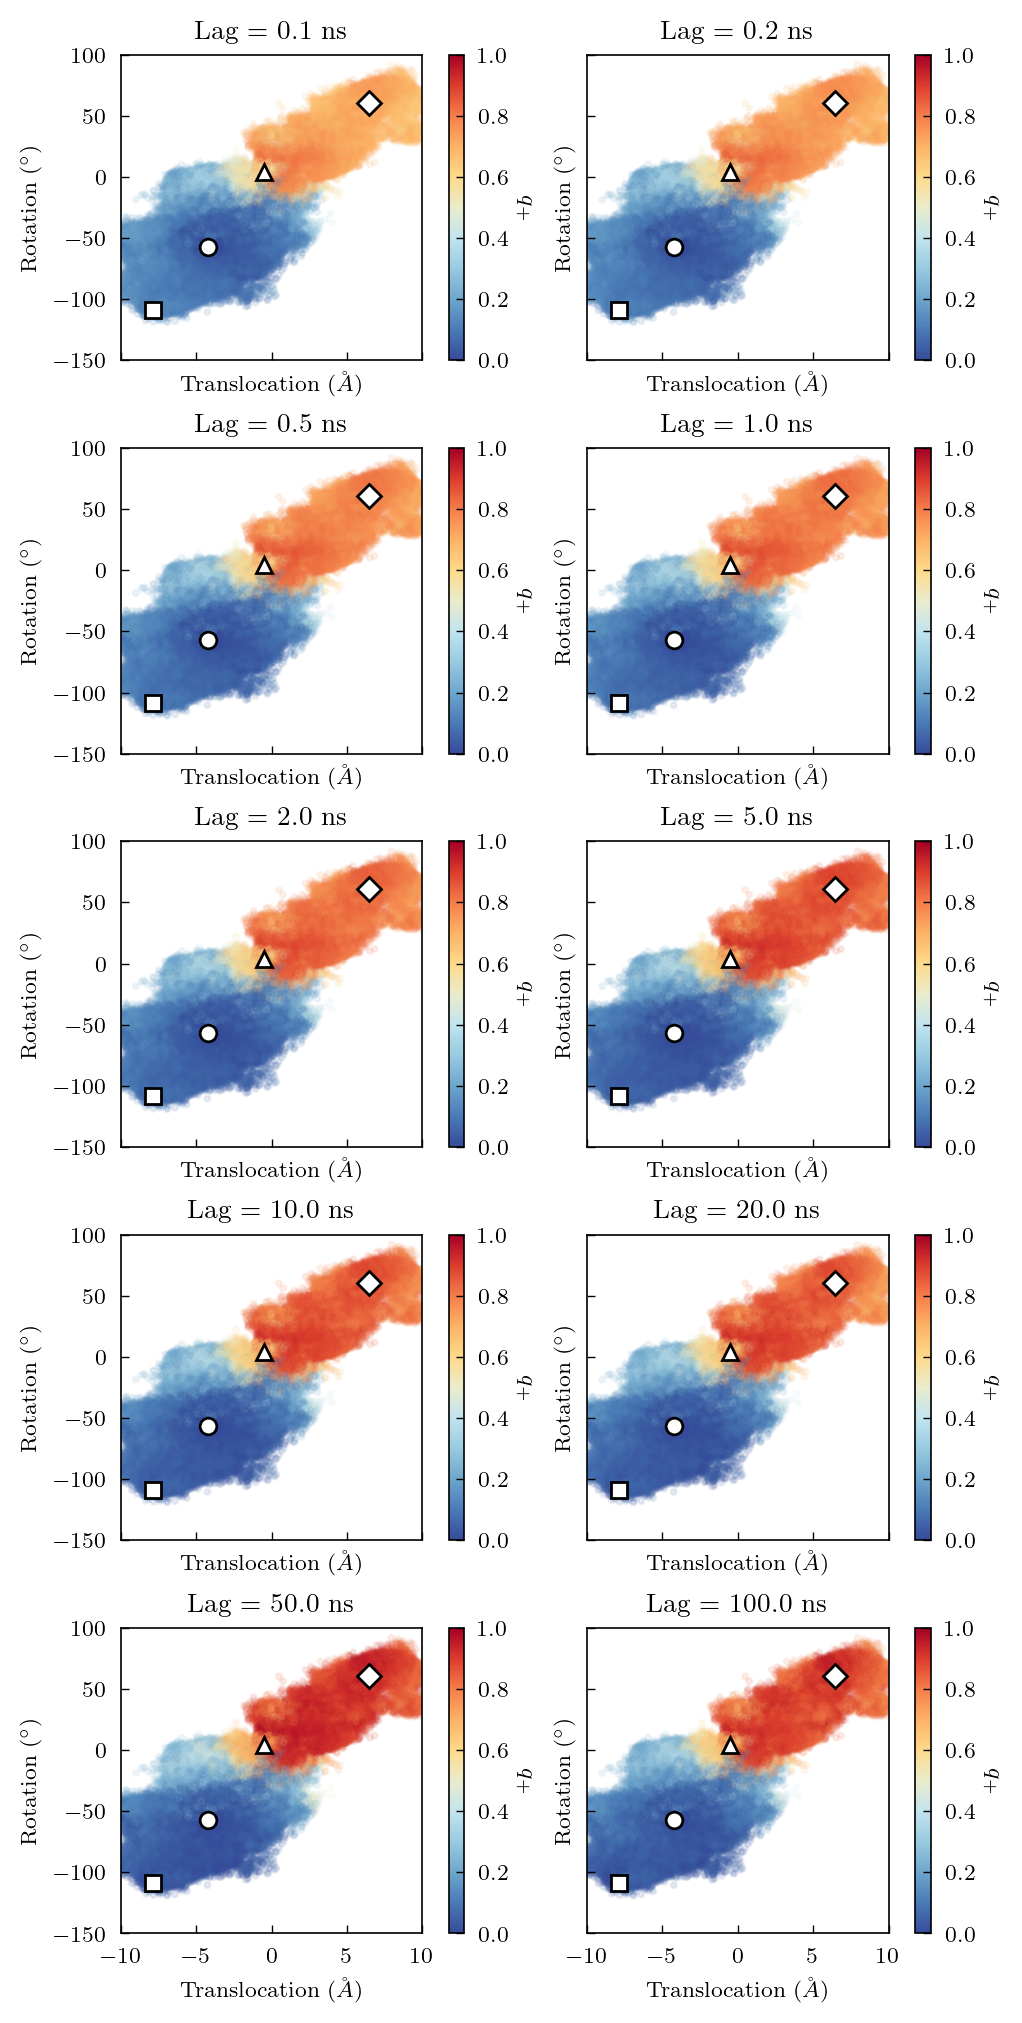

In [40]:
f, axs = plt.subplots(
    5, 2, figsize=(5, 10), sharex=True, sharey=True, dpi=200, constrained_layout=True
)
for lag, q, ax in zip(lags, q_downup, axs.flat):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*cv_arr[inds].T, c=q_arr[inds], cmap=cm_div, alpha=0.1)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True, ms=6)
    cbar.set_label("$q_+$", rotation=-90, labelpad=10)

In [42]:
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


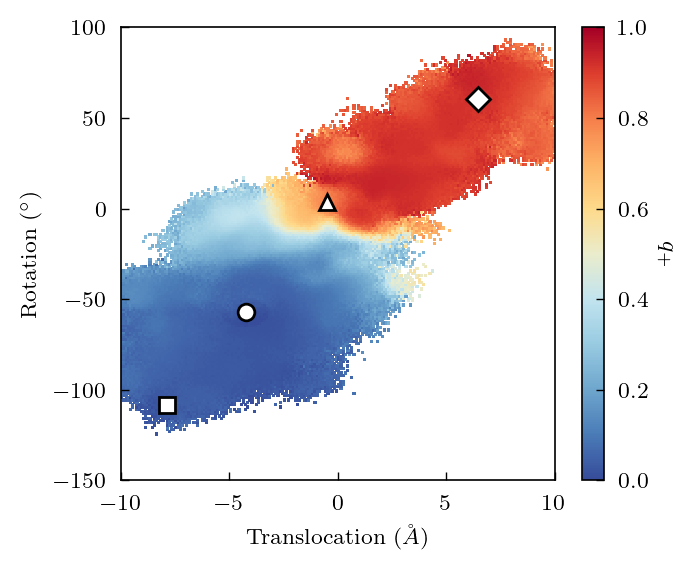

In [43]:
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
q_dens = extq.projection.average2d(
    dist_trajs, rot_trajs, q_downup[8], weights[0], xe, ye
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, q_dens.T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)
# plt.savefig("../../fig/committors/q_feat2_dist_du_anton2_3_ds_50ns_bin.png", dpi=300)

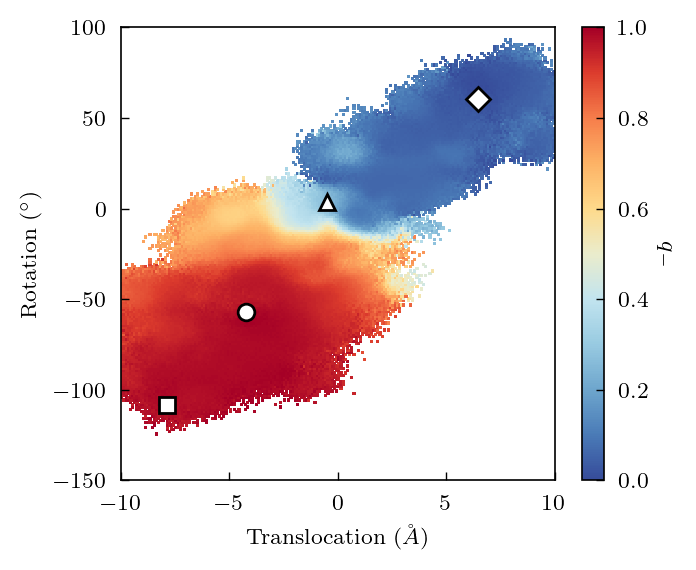

In [44]:
xe = np.linspace(-10, 10, 201)
ye = np.linspace(-150, 100, 201)
qb_dens = extq.projection.average2d(
    dist_trajs, rot_trajs, qb_downup[8], weights[0], xe, ye
)

f, ax = plt.subplots(figsize=(3.5, 3), dpi=200)
h = ax.pcolor(xe, ye, qb_dens.T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_-$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True, ms=6)
# plt.savefig("../../fig/committors/qm_feat2_dist_du_anton2_3_ds_50ns_bin.png", dpi=300)

In [46]:
sb_ids = [42, 48, 47, 53]

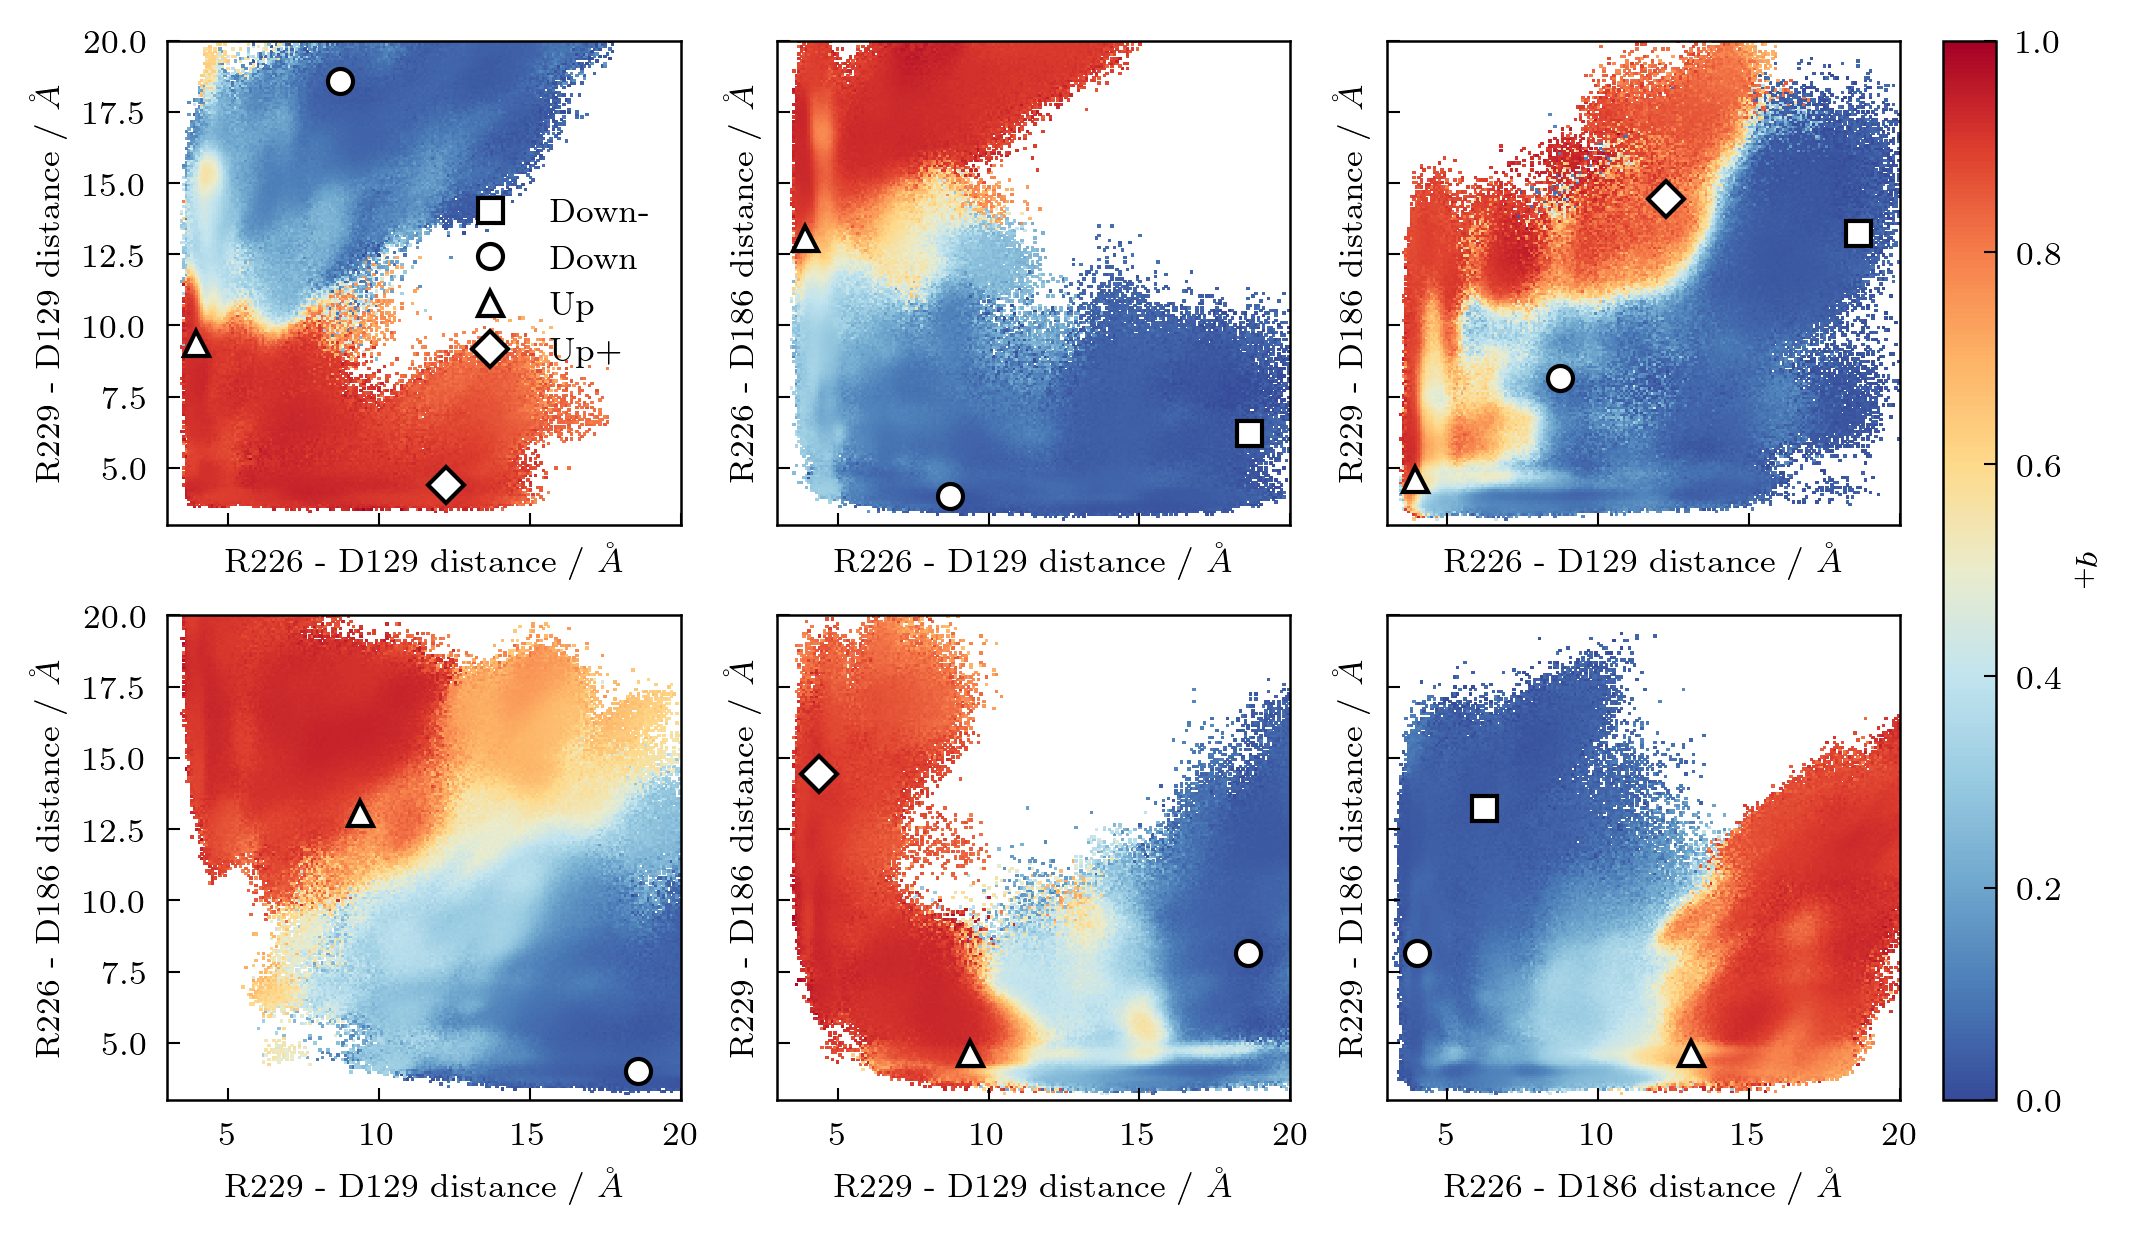

In [47]:
f, axes = plotting.plot_sb_q(
    sb_ids,
    sb_trajs,
    q_downup[8],
    weights[0],
    centroids=True,
    fig_kwargs={
        "sharex": True,
        "sharey": True,
        "constrained_layout": True,
        "figsize": (7, 4),
        "dpi": 300,
    },
    bins=200,
    ms=6,
)

axes.flat[0].legend(loc="right")